In [1]:
import tejapi as tej
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

tej.ApiConfig.api_key = 'Your Key'

plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']

### 找到所需的會計科目名稱：
### R505負債比率、單月營收、R108稅後淨利率、PSR:市值/近一年月營收、PRR:市值/近一年3368研發費用

In [2]:
financial_name = tej.get('TWN/AIACC', chinese_column_name=True, paginate=True) #找尋所需的會計科目

financial_dict = ['負債比率', '稅後淨利率', '研發費用']

a = []
for i in financial_dict:
    a.append(financial_name[financial_name['中文全稱'].str.contains(i)]['會計科目'].mode().to_list())

In [3]:
a 

[['R505'], ['R108'], ['3368']]

### 下載15~22年間所有上市櫃相關財報資料

In [4]:
#上市櫃公司代號
code = tej.get('TWN/ANPRCSTD', mdate={'lt':'2022-10-14'}, chinese_column_name=True, paginate=True)
all_code = code[(code['證券種類名稱'] == '普通股') & (code['上市別'].isin(['TSE', 'OTC']))]['證券碼'].to_list()

In [5]:
#下載近十年的財務數據
financial_data = tej.get('TWN/AIFINQ', 
                            coid=all_code, 
                            mdate={'gt': '2012-01-01', 'lt':'2022-10-14'}, 
                            acc_code=a,
                            chinese_column_name=True, 
                            paginate=True)
financial_data = financial_data.reset_index(drop=True)

In [6]:
#下載近十年的月營收數據
revenue_data = tej.get('TWN/ASALE', 
                            coid=all_code, 
                            mdate={'gt': '2011-12-31', 'lt':'2022-10-14'}, 
                            opts={'columns': ['coid', 'mdate', 'd0001']},
                            chinese_column_name=True, 
                            paginate=True)
revenue_data.rename(columns={'年月': '年/月'}, inplace=True)
revenue_data['公司'] = revenue_data['公司'].astype(int)
revenue_data = revenue_data.astype({'年/月':'datetime64[ns]'})

C:\Users\terry\AppData\Local\Temp\ipykernel_11704\4154287080.py:10: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  revenue_data = revenue_data.astype({'年/月':'datetime64[ns]'})


### 下載12~22年間所有股價資料

In [8]:
m = pd.date_range('2011-12-31', '2022-11-01', freq='1M', inclusive='both').to_list()

price = pd.DataFrame()

for i in range(1, len(m)):
    price = pd.concat([price, tej.get('TWN/APRCD1', 
                                coid=all_code, 
                                mdate={'gt': m[i-1], 'lt':m[i]}, 
                                opts={'columns': ['coid', 'mdate', 'close_adj', 'mv']},
                                chinese_column_name=True, 
                                paginate=True)])

price = price.reset_index(drop=True)
price = price.rename(columns={'證券代碼':'公司', '年月日':'年/月'})
price['公司'] = price['公司'].astype(int)
price = price.astype({'年/月':'datetime64[ns]'})

C:\Users\terry\AppData\Local\Temp\ipykernel_11704\24625519.py:16: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  price = price.astype({'年/月':'datetime64[ns]'})


In [9]:
price 

,公司,年/月,收盤價(元),市值(百萬元)
0,1101,2012-01-02,14.5382,128119
1,1101,2012-01-03,14.8315,130703
2,1101,2012-01-04,14.9153,131441
3,1101,2012-01-05,14.9153,131441
4,1101,2012-01-06,14.6429,129042
...,...,...,...,...
3769643,9962,2022-10-11,14.4500,1304
3769644,9962,2022-10-12,14.0500,1268
3769645,9962,2022-10-13,12.9000,1164
3769646,9962,2022-10-14,13.3500,1204


### 指標計算: 負債比率<35%、最近5年平均營收成長率≧15%、最近5年平均稅後淨利率≧5%、股價營收比(PSR)≦1.5、股價／研發費用比(PRR) ≦15

In [10]:
financial_data1 = financial_data.copy()
financial_data1['數值'] = financial_data1['數值'].astype(float)

financial_data1['會計科目'] = financial_data1['會計科目'].map({'R505':'負債比率',    #會計科目改名
                                                            'R108':'稅後淨利率',
                                                            '3368':'研發費用'})
                                                    
financial_data1 = financial_data1.pivot_table(index=['公司', '年/月'], columns='會計科目', values='數值').reset_index()  #格式轉置
financial_data1['公司'] = financial_data1['公司'].astype(int)
financial_data1 = financial_data1.astype({'年/月':'datetime64[ns]'})

C:\Users\terry\AppData\Local\Temp\ipykernel_11704\4163908289.py:10: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  financial_data1 = financial_data1.astype({'年/月':'datetime64[ns]'})


In [11]:
financial_data1

會計科目,公司,年/月,研發費用,稅後淨利率,負債比率
0,1101,2012-03-01,8942.0,8.37,47.80
1,1101,2012-06-01,20296.0,9.65,51.20
2,1101,2012-09-01,21330.0,8.68,48.99
3,1101,2012-12-01,33105.0,8.43,48.24
4,1101,2013-03-01,11268.0,8.29,46.72
...,...,...,...,...,...
65462,9962,2021-06-01,NaN,5.45,22.58
65463,9962,2021-09-01,NaN,6.26,39.97
65464,9962,2021-12-01,NaN,6.56,35.41
65465,9962,2022-03-01,NaN,4.44,24.53


In [12]:
financial_data1 = pd.merge_asof(revenue_data.sort_values('年/月'), financial_data1.sort_values('年/月'), on='年/月', by='公司', direction='backward').sort_values(['公司', '年/月'])
financial_data1 = pd.merge_asof(financial_data1.sort_values('年/月'), price.sort_values('年/月'), on='年/月', by='公司', direction='nearest').sort_values(['公司', '年/月'])

In [13]:
financial_data1

,公司,年/月,單月營收(千元),研發費用,稅後淨利率,負債比率,收盤價(元),市值(百萬元)
0,1101,2012-01-01,1752202.0,NaN,NaN,NaN,14.5382,128119
1886,1101,2012-02-01,1723441.0,NaN,NaN,NaN,15.2085,134026
4052,1101,2012-03-01,2091998.0,8942.0,8.37,47.80,15.6066,137534
4283,1101,2012-04-01,2032715.0,8942.0,8.37,47.80,14.3287,126272
6566,1101,2012-05-01,2047477.0,8942.0,8.37,47.80,14.8943,131257
...,...,...,...,...,...,...,...,...
197529,9962,2022-05-01,228412.0,NaN,4.44,24.53,17.2820,1692
198064,9962,2022-06-01,387082.0,NaN,7.31,31.41,15.6690,1534
199640,9962,2022-07-01,248327.0,NaN,7.31,31.41,12.2000,1101
201722,9962,2022-08-01,318092.0,NaN,7.31,31.41,15.8500,1430


In [14]:
financial_data1['營收年成長率'] = financial_data1['單月營收(千元)'] / financial_data1['單月營收(千元)'].shift(12)

financial_data1['平均5年營收成長率'] = financial_data1.groupby('公司')['營收年成長率'].transform(lambda x: x.rolling(60).mean())
financial_data1['平均5年稅後淨利率'] = financial_data1.groupby('公司')['稅後淨利率'].transform(lambda x: x.rolling(60).mean())

financial_data1['近一年營收總合'] = financial_data1.groupby('公司')['單月營收(千元)'].transform(lambda x: x.rolling(12).sum()/1000)
financial_data1['股價營收比'] = financial_data1['市值(百萬元)'] / financial_data1['近一年營收總合']

financial_data1['近一年研發總合'] = financial_data1.groupby('公司')['研發費用'].transform(lambda x: x.rolling(12).sum()/1000)
financial_data1['股價研發比'] = financial_data1['市值(百萬元)'] / financial_data1['近一年研發總合']

In [15]:
financial_data2 = financial_data1[['公司', '年/月', '負債比率', '收盤價(元)', '平均5年營收成長率', '平均5年稅後淨利率', '股價營收比', '股價研發比']].reset_index(drop=True)

In [16]:
financial_data2

,公司,年/月,負債比率,收盤價(元),平均5年營收成長率,平均5年稅後淨利率,股價營收比,股價研發比
0,1101,2012-01-01,NaN,14.5382,NaN,NaN,NaN,NaN
1,1101,2012-02-01,NaN,15.2085,NaN,NaN,NaN,NaN
2,1101,2012-03-01,47.80,15.6066,NaN,NaN,NaN,NaN
3,1101,2012-04-01,47.80,14.3287,NaN,NaN,NaN,NaN
4,1101,2012-05-01,47.80,14.8943,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
204457,9962,2022-05-01,24.53,17.2820,1.121627,2.163000,0.542494,NaN
204458,9962,2022-06-01,31.41,15.6690,1.128230,2.312833,0.480278,NaN
204459,9962,2022-07-01,31.41,12.2000,1.134070,2.462667,0.338844,NaN
204460,9962,2022-08-01,31.41,15.8500,1.149276,2.612500,0.422695,NaN


### 策略篩選

In [123]:
def condition(df, n1, n2, n3, n4, n5):
    price_T = price.pivot_table(index='年/月', columns='公司', values='收盤價(元)')

    target_stock = df[(df['負債比率'] < n1) & (df['平均5年營收成長率'] >= n2) & (df['平均5年稅後淨利率'] >= n3) & (df['股價營收比'] <= n4) & (df['股價研發比'] <= n5)]

    target_Q = list(target_stock.groupby('年/月')[['公司', '年/月', '收盤價(元)']])

    ret, daily_ret = [], []
    for i in range(len(target_Q)):
        daily_ret.append(price_T.loc[target_Q[i][1].iloc[0]['年/月']:target_Q[i][1].iloc[0]['年/月']+pd.DateOffset(months=1), target_Q[i][1]['公司'].to_list()])
        ret.append(price_T.loc[target_Q[i][1].iloc[0]['年/月']:target_Q[i][1].iloc[0]['年/月']+pd.DateOffset(months=1), target_Q[i][1]['公司'].to_list()].pct_change().mean(axis=1))

    ret_table = pd.concat(ret)

    ret_table = pd.DataFrame(columns=['投組日報酬'], data=ret_table).dropna()

    ret_table['投組累積報酬'] = (ret_table['投組日報酬'] +1).cumprod()



    ret_table.reset_index(inplace=True)

    print('年化報酬率:',"%6.3f" % (ret_table['投組日報酬'].mean()*252))
    print('年化標準差:',"%6.3f" % (ret_table['投組日報酬'].std()*np.sqrt(252)))
    print('年化夏普:',"%6.4f" % (ret_table['投組日報酬'].mean()*252 / (ret_table['投組日報酬'].std()*np.sqrt(252))))


    return ret_table, target_stock[['公司', '年/月', '收盤價(元)']], daily_ret

In [18]:
ret_table, target_stock, daily_ret = condition(financial_data1, 35, 15, 5, 1.5, 15)
ret_table

年化報酬率:  0.250
年化標準差:  0.253
年化夏普: 0.9876


,年/月,投組日報酬,投組累積報酬
0,2017-02-03,0.019334,1.019334
1,2017-02-06,0.020656,1.040389
2,2017-02-07,0.000323,1.040725
3,2017-02-08,0.003820,1.044701
4,2017-02-09,-0.008778,1.035531
...,...,...,...
430,2020-10-26,-0.008438,1.468495
431,2020-10-27,0.002837,1.472661
432,2020-10-28,-0.002829,1.468495
433,2020-10-29,0.000000,1.468495


### 指標比較

In [19]:
y9997 = tej.get('TWN/APRCD1', 
            coid='y9997', 
            mdate={'gt': '2017-02-01', 'lt':'2022-10-14'}, 
            opts={'columns': ['coid', 'mdate', 'close_adj']},
            chinese_column_name=True, 
            paginate=True)

y9997['基準日報酬'] = y9997['收盤價(元)'].pct_change()

y9997['基準累積報酬'] = (y9997['基準日報酬']+1).cumprod()

y9997.rename(columns={'年月日':'年/月'}, inplace=True)

y9997 = y9997.astype({'年/月':'datetime64[ns]'})

C:\Users\terry\AppData\Local\Temp\ipykernel_11704\3803379265.py:14: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  y9997 = y9997.astype({'年/月':'datetime64[ns]'})


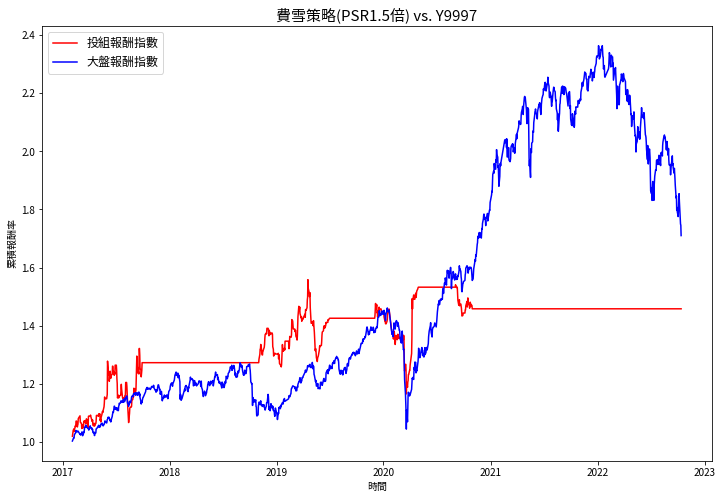

In [114]:
ret_result1 = pd.merge(y9997, ret_table, how='outer')

ret_result1['投組累積報酬'].fillna(method='ffill', inplace=True)

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(ret_result1['年/月'], ret_result1['投組累積報酬'], label='投組報酬指數', color='red')

ax.plot(ret_result1['年/月'], ret_result1['基準累積報酬'], label='大盤報酬指數', color='blue')

ax.legend(loc='upper left', fontsize=12)

ax.set_title('費雪策略(PSR1.5倍) vs. Y9997', fontsize=15)
ax.set_xlabel('時間')
ax.set_ylabel('累積報酬率')

plt.show()

In [125]:
ret_table2, target_stock2, daily_ret2 = condition(financial_data1, 35, 15, 5, 2, 15)

ret_table2

年化報酬率:  0.598
年化標準差:  0.330
年化夏普: 1.8135


,年/月,投組日報酬,投組累積報酬
0,2017-02-03,0.019334,1.019334
1,2017-02-06,0.020656,1.040389
2,2017-02-07,0.000323,1.040725
3,2017-02-08,0.003820,1.044701
4,2017-02-09,-0.008778,1.035531
...,...,...,...
570,2020-10-26,-0.008438,3.488516
571,2020-10-27,0.002837,3.498414
572,2020-10-28,-0.002829,3.488516
573,2020-10-29,0.000000,3.488516


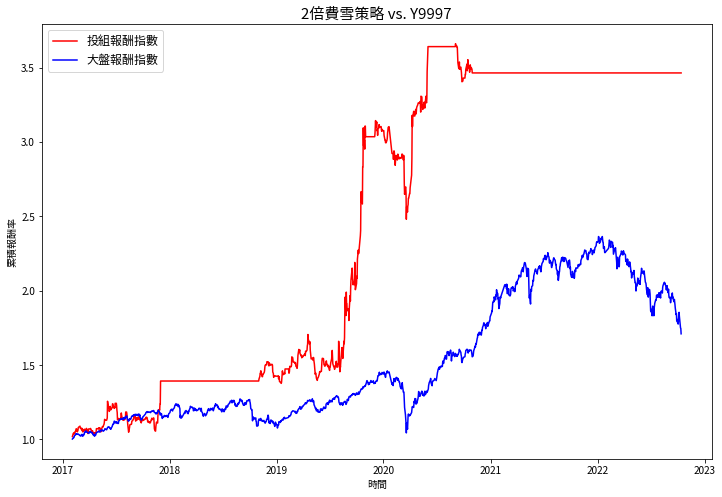

In [116]:
ret_result = pd.merge(y9997, ret_table2, how='outer')

ret_result['投組累積報酬'].fillna(method='ffill', inplace=True)

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(ret_result['年/月'], ret_result['投組累積報酬'], label='投組報酬指數', color='red')

ax.plot(ret_result['年/月'], ret_result['基準累積報酬'], label='大盤報酬指數', color='blue')

ax.legend(loc='upper left', fontsize=12)

ax.set_title('2倍費雪策略 vs. Y9997', fontsize=15)
ax.set_xlabel('時間')
ax.set_ylabel('累積報酬率')

plt.show()

In [126]:
(pd.concat(daily_ret2)['2019-08-01': '2019-12-01'].pct_change()+1).cumprod()

公司,3078,4908,8299,3118,6494,6538,6577
年/月,,,,,,,
2019-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-01,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
2019-08-02,NaN,NaN,NaN,NaN,NaN,0.973010,NaN
2019-08-05,NaN,NaN,NaN,NaN,NaN,0.876420,NaN
2019-08-06,NaN,NaN,NaN,NaN,NaN,0.906250,NaN
...,...,...,...,...,...,...,...
2019-10-25,NaN,NaN,NaN,NaN,NaN,1.797221,NaN
2019-10-28,NaN,NaN,NaN,NaN,NaN,1.818787,NaN
2019-10-29,NaN,NaN,NaN,NaN,NaN,1.782843,NaN


In [70]:
ret_table['Y'] = ret_table['年/月'].dt.year
ret_table['M'] = ret_table['年/月'].dt.month
ret_table.groupby(['Y', 'M'])['投組累積報酬'].apply(lambda x: x.iloc[-1])

Y     M 
2017  2     1.081771
      3     1.070353
      4     1.072679
      5     1.129308
      6     1.242973
      7     1.131937
      8     1.136181
      9     1.135730
      10    1.130726
      11    1.237400
      12    1.392797
2018  11    1.522300
      12    1.425406
2019  1     1.473853
      2     1.519595
      3     1.558748
      4     1.541615
      5     1.457308
      6     1.483733
      7     1.508988
      8     1.866281
      9     2.006730
      10    3.106501
      11    3.035088
      12    3.075734
2020  1     2.922400
      2     2.891452
      3     2.652710
      4     3.262831
      5     3.471763
      6     3.640685
      9     3.429133
      10    3.463776
Name: 投組累積報酬, dtype: float64